In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from PIL import Image
import glob
import os
from tqdm import tqdm
import numpy as np
import torch.nn.functional as F
import torchvision.models as models
import cv2

In [2]:
image_size = 256

class ImageDataset(Dataset):
    def __init__(self, paths, transform=None, masked_size=100):
        self.paths = paths
        self.transform = transform
        self.masked_size = masked_size

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        img_path = self.paths[idx]
        img = Image.open(img_path).convert("RGB")
        masked_img = img.copy()
        masked_img = np.array(masked_img)
        
        if self.transform:
            img = self.transform(img)

        if self.masked_size:
            h = np.random.randint(0, image_size - self.masked_size)
            w = np.random.randint(0, image_size - self.masked_size)
            mask = np.ones((image_size, image_size, 3), dtype=np.float32)
            mask[h:h+self.masked_size, w:w+self.masked_size] = 0
            mask = torch.from_numpy(mask)
            mask = mask.permute(2, 0, 1)
            masked_img[h:h+self.masked_size, w:w+self.masked_size] = 0
            masked_img = Image.fromarray(masked_img)
            masked_img = self.transform(masked_img)

        return img, masked_img, mask
    
    @staticmethod
    def collate_fn(batch):
        image, masked_image, mask = zip(*batch)
        image = torch.stack(image, dim=0)
        masked_image = torch.stack(masked_image, dim=0)
        mask = torch.stack(mask, dim=0)
        return image, masked_image, mask

    
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

image_dir = "testSet_resize"
image_paths = glob.glob(os.path.join(image_dir, "*.jpg"))  # Adjust the file extension if needed

train_dataset = ImageDataset(image_paths, transform)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, collate_fn=ImageDataset.collate_fn, pin_memory=True)


In [3]:
class UNetDown(nn.Module):
    def __init__(self, in_size, out_size, normalize=True, dropout=0.0):
        super(UNetDown, self).__init__()
        layers = [nn.Conv2d(in_size, out_size, kernel_size=3, stride=2, padding=1, bias=False)]
        if normalize:
            layers.append(nn.BatchNorm2d(out_size, 0.8))
        layers.append(nn.LeakyReLU(0.2))
        if dropout:
            layers.append(nn.Dropout(dropout))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)
    
class UNetUp(nn.Module):
    def __init__(self, in_size, out_size, dropout=0.0):
        super(UNetUp, self).__init__()
        layers = [
            nn.ConvTranspose2d(in_size, out_size, kernel_size=3, stride=2, padding=1, output_padding=1, bias=False),
            nn.BatchNorm2d(out_size, 0.8),
            nn.ReLU(inplace=True),
        ]
        if dropout:
            layers.append(nn.Dropout(dropout))
        self.model = nn.Sequential(*layers)

    def forward(self, x, skip_input):
        x = self.model(x)
        x = torch.cat((x, skip_input), 1)

        return x

class ResidualBlock(nn.Module):
    def __init__(self, in_channels):
        super(ResidualBlock, self).__init__()

        self.block = nn.Sequential(
            nn.Conv2d(in_channels, in_channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(in_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels, in_channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(in_channels)
        )

    def forward(self, x):
        residual = x
        out = self.block(x)
        out += residual
        return out

class Generator(nn.Module):
    def __init__(self, in_channels=3, out_channels=3, num_residual_blocks=3):
        super(Generator, self).__init__()

        self.down1 = UNetDown(in_channels, 64, normalize=False)
        self.down2 = UNetDown(64, 128)
        self.down3 = UNetDown(128, 256)
        self.down4 = UNetDown(256, 512, dropout=0.5)
        self.down5 = UNetDown(512, 512, dropout=0.5)
        self.down6 = UNetDown(512, 512, dropout=0.5)
        self.down7 = UNetDown(512, 512, dropout=0.5)
        self.down8 = UNetDown(512, 512, normalize=False, dropout=0.5)

        self.residual_blocks = nn.Sequential(
            *[ResidualBlock(512) for _ in range(num_residual_blocks)]
        )

        self.up1 = UNetUp(512, 512, dropout=0.5)
        self.up2 = UNetUp(1024, 512, dropout=0.5)
        self.up3 = UNetUp(1024, 512, dropout=0.5)
        self.up4 = UNetUp(1024, 512, dropout=0.5)
        self.up5 = UNetUp(1024, 256)
        self.up6 = UNetUp(512, 128)
        self.up7 = UNetUp(256, 64)

        self.final = nn.Sequential(
            nn.ConvTranspose2d(128, out_channels, kernel_size=4, stride=2, padding=1),
            nn.Tanh()
        )

    def forward(self, x, mask):
        d1 = self.down1(x)
        d2 = self.down2(d1)
        d3 = self.down3(d2)
        d4 = self.down4(d3)
        d5 = self.down5(d4)
        d6 = self.down6(d5)
        d7 = self.down7(d6)
        d8 = self.down8(d7)

        d8 = self.residual_blocks(d8)

        u1 = self.up1(d8, d7)
        u2 = self.up2(u1, d6)
        u3 = self.up3(u2, d5)
        u4 = self.up4(u3, d4)
        u5 = self.up5(u4, d3)
        u6 = self.up6(u5, d2)
        u7 = self.up7(u6, d1)
        
        inpaint = self.final(u7)

        return inpaint

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0),
        )
        self.fc = nn.Linear(13 * 13, 1)

    def forward(self, img):
        x = self.model(img)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return torch.sigmoid(x)

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

generator = Generator().to(device)
discriminator = Discriminator().to(device)

criterion = nn.MSELoss()

optimizer_G = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

num_epochs = 20

def generator_loss(fake_output, real_image, generated_image, lambda_l1=100):
    # Adversarial loss
    adversarial_loss = criterion(fake_output, torch.ones_like(fake_output))
    
    # Reconstruction loss (L1 loss)
    l1_loss = F.l1_loss(generated_image, real_image)

    # Total generator loss
    total_gen_loss = adversarial_loss + lambda_l1 * l1_loss
    
    return total_gen_loss

def discriminator_loss(real_output, fake_output):
    real_loss = criterion(real_output, torch.ones_like(real_output))
    fake_loss = criterion(fake_output, torch.zeros_like(fake_output))
    
    total_disc_loss = 0.5 * (real_loss + fake_loss)
    
    return total_disc_loss

for epoch in tqdm(range(num_epochs)):
    for images, masked_images, masks in train_loader:
        images = images.to(device)
        masked_images = masked_images.to(device)
        masks = masks.to(device)
        optimizer_D.zero_grad()

        real_labels = torch.ones(images.size(0), 1).to(device)
        fake_labels = torch.zeros(images.size(0), 1).to(device)

        real_output = discriminator(images)

        fake_images = generator(masked_images, masks)

        fake_output = discriminator(fake_images.detach())

        d_loss = discriminator_loss(real_output, fake_output)
        d_loss.backward()
        optimizer_D.step()

        # Train the generator
        optimizer_G.zero_grad()

        fake_output = discriminator(fake_images)
        g_loss = generator_loss(fake_output, images, fake_images)
        g_loss.backward()
        optimizer_G.step()

    print(f"[{epoch+1}/{num_epochs}] Loss_D: {d_loss.item():.4f} Loss_G: {g_loss.item():.4f}")



  5%|▌         | 1/20 [04:06<1:18:09, 246.83s/it]

[1/20] Loss_D: 0.0001 Loss_G: 43.1612


 10%|█         | 2/20 [07:31<1:06:40, 222.25s/it]

[2/20] Loss_D: 0.0000 Loss_G: 39.5168


 15%|█▌        | 3/20 [10:58<1:00:56, 215.10s/it]

[3/20] Loss_D: 0.0000 Loss_G: 45.6992


 20%|██        | 4/20 [14:17<55:39, 208.74s/it]  

[4/20] Loss_D: 0.0000 Loss_G: 40.5908


 25%|██▌       | 5/20 [17:34<51:10, 204.67s/it]

[5/20] Loss_D: 0.0000 Loss_G: 37.8023


 30%|███       | 6/20 [20:53<47:16, 202.63s/it]

[6/20] Loss_D: 0.0000 Loss_G: 38.4009


 35%|███▌      | 7/20 [24:30<44:55, 207.35s/it]

[7/20] Loss_D: 0.0000 Loss_G: 37.3069


 40%|████      | 8/20 [28:09<42:11, 210.97s/it]

[8/20] Loss_D: 0.0000 Loss_G: 38.1660


 45%|████▌     | 9/20 [31:10<36:57, 201.60s/it]

[9/20] Loss_D: 0.0000 Loss_G: 40.0418


 50%|█████     | 10/20 [34:38<33:57, 203.74s/it]

[10/20] Loss_D: 0.0000 Loss_G: 36.6753


 55%|█████▌    | 11/20 [38:07<30:46, 205.22s/it]

[11/20] Loss_D: 0.0000 Loss_G: 35.5104


 60%|██████    | 12/20 [41:39<27:38, 207.36s/it]

[12/20] Loss_D: 0.0000 Loss_G: 42.1268


 65%|██████▌   | 13/20 [45:08<24:14, 207.73s/it]

[13/20] Loss_D: 0.0000 Loss_G: 37.5078


 70%|███████   | 14/20 [48:36<20:47, 207.97s/it]

[14/20] Loss_D: 0.0000 Loss_G: 37.5633


 75%|███████▌  | 15/20 [52:04<17:19, 207.88s/it]

[15/20] Loss_D: 0.0000 Loss_G: 39.1615


 80%|████████  | 16/20 [55:35<13:55, 208.85s/it]

[16/20] Loss_D: 0.0000 Loss_G: 34.0997


 85%|████████▌ | 17/20 [59:02<10:24, 208.20s/it]

[17/20] Loss_D: 0.0000 Loss_G: 38.5543


 90%|█████████ | 18/20 [1:02:29<06:55, 207.84s/it]

[18/20] Loss_D: 0.0000 Loss_G: 35.9930


 95%|█████████▌| 19/20 [1:05:56<03:27, 207.77s/it]

[19/20] Loss_D: 0.0000 Loss_G: 38.4457


100%|██████████| 20/20 [1:09:33<00:00, 208.70s/it]

[20/20] Loss_D: 0.0000 Loss_G: 40.5064


In [5]:
torch.save(generator.state_dict(), 'generator_res_whole.pth')
torch.save(discriminator.state_dict(), 'discriminator_res_whole.pth')

In [6]:
def color_correction(image, inpainting_mask, inpainting_border=5):
    # Dilate the inpainting mask to include the surrounding area
    kernel = np.ones((inpainting_border, inpainting_border), np.uint8)
    expanded_mask = cv2.dilate(inpainting_mask, kernel, iterations=1)

    # Calculate the mean color of the inpainted region
    inpainted_mean = cv2.mean(image, mask=inpainting_mask)[:3]

    # Calculate the mean color of the surrounding area
    surrounding_mask = cv2.bitwise_xor(expanded_mask, inpainting_mask)
    surrounding_mean = cv2.mean(image, mask=surrounding_mask)[:3]

    # Calculate the color correction factor
    correction_factor = np.array(surrounding_mean) / np.array(inpainted_mean)

    # Apply the color correction to the inpainted region
    corrected_image = image.copy()
    for i in range(3):
        corrected_image[:, :, i] = (corrected_image[:, :, i].astype(np.float32) * correction_factor[i]).clip(0, 255).astype(np.uint8)

    # Combine the corrected inpainted part with the original image
    corrected_image = cv2.add(cv2.bitwise_and(corrected_image, corrected_image, mask=inpainting_mask), cv2.bitwise_and(image, image, mask=cv2.bitwise_not(inpainting_mask)))

    return corrected_image

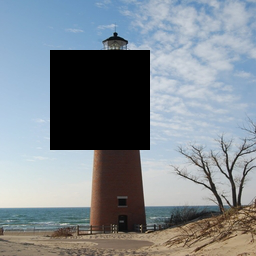

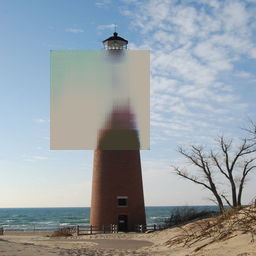

After color correction


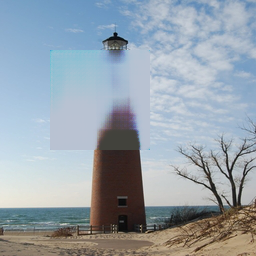

In [7]:
generator = Generator().to("cuda")
discriminator = Discriminator().to("cuda")
generator.load_state_dict(torch.load("generator_res_whole.pth"))
discriminator.load_state_dict(torch.load("discriminator_res_whole.pth"))
image = Image.open("testSet_resize/1.jpg")
image = np.array(image)
image[50:150, 50:150] = 0
mask = np.ones((image.shape[0], image.shape[1], 3))
mask[50:150, 50:150] = 0
mask = torch.tensor(mask).to("cuda")
mask = mask.permute(2, 0, 1)
image = Image.fromarray(image)
display(image)
image = transform(image).to("cuda")
image = image.unsqueeze(0)
mask = mask.unsqueeze(0)
generator.eval()
inpaint = generator(image, mask)
inpaint = inpaint.squeeze(0)
inpaint = inpaint.detach().cpu()
mask = mask.cpu().squeeze(0)
inpaint = image.cpu().squeeze(0) * mask + inpaint * (1 - mask)
mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
inpaint = inpaint * std + mean
inpaint = inpaint.detach().numpy()
inpaint = np.transpose(inpaint, (1, 2, 0))
inpaint = (inpaint * 255).astype(np.uint8)
inpaint1 = inpaint.copy()
mask = np.zeros((256, 256), dtype=np.uint8)
mask[50:150, 50:150] = 255
inpaint1 = color_correction(inpaint1, mask)
inpaint = Image.fromarray(inpaint)
inpaint1 = Image.fromarray(inpaint1)
display(inpaint)
print("After color correction")
display(inpaint1)